In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Bronze analysis

In [100]:
BRONZE_PATH = "messages_bronze"
df = pd.read_parquet(BRONZE_PATH)
print(f"rows={len(df):,}  cols={df.shape[1]}  partitions: date/hour present ->",
      {"date" in df, "hour" in df})

rows=10,000  cols=15  partitions: date/hour present -> {True}


In [101]:
display(df.head(3))
display(df.dtypes)
display(df.isna().sum().sort_values(ascending=False).to_frame("nulls"))

,vin,manufacturer,year,model,latitude,longitude,timestamp,velocity,frontLeftDoorState,wipersState,gearPosition,driverSeatbeltState,ts_utc,date,hour
0,9BWEL41J484018815,Volkswagen,2008,Golf,41.39,-99.05,1754823429113,100,LOCKED,False,5,None,2025-08-10 10:57:09.113000+00:00,2025-08-10,10
1,KMHFC46F87A211273,Hyundai,2007,Azeraz,40.34,-93.16,1754823343110,0,LOCKED,False,0,None,2025-08-10 10:55:43.110000+00:00,2025-08-10,10
2,JTHBN36F665857215,Lexus,2006,LS 430,40.31,-106.45,1754822873103,130,UNLOCKED,False,1,LOCKED,2025-08-10 10:47:53.103000+00:00,2025-08-10,10


vin                                 object
manufacturer                        object
year                                 int64
model                               object
latitude                           float64
longitude                          float64
timestamp                            int64
velocity                             int64
frontLeftDoorState                  object
wipersState                         object
gearPosition                        object
driverSeatbeltState                 object
ts_utc                 datetime64[ns, UTC]
date                              category
hour                              category
dtype: object

,nulls
driverSeatbeltState,2044
frontLeftDoorState,1990
gearPosition,1018
wipersState,591
vin,441
manufacturer,0
year,0
model,0
latitude,0
longitude,0


In [102]:
print(f"#Unique VINs: {df['vin'].nunique()}")

#Unique VINs: 22


In [103]:
df["ts_utc"] = pd.to_datetime(df["timestamp"], unit="ms", utc=True, errors="coerce")
print("ts range:", df["ts_utc"].min(), "→", df["ts_utc"].max())
print(df.groupby(["date","hour"]).size().tail())

ts range: 2025-08-10 10:44:36.107000+00:00 → 2025-08-10 11:44:34.110000+00:00
date        hour
2025-08-10  10      2631
            11      7369
dtype: int64


/var/folders/wg/fhyh82z92tggqh_lpzr0bhf00000gn/T/ipykernel_24526/212674057.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(["date","hour"]).size().tail())


In [104]:
for c in ["gearPosition","driverSeatbeltState","frontLeftDoorState","wipersState","manufacturer","model"]:
    if c in df:
        print(f"\nValue counts: {c}")
        display(df[c].value_counts(dropna=False).head(10))


Value counts: gearPosition


gearPosition
1          2016
5          1530
3          1187
4          1163
6          1058
None       1018
2           942
0           513
NEUTRAL     471
-1           51
Name: count, dtype: int64


Value counts: driverSeatbeltState


driverSeatbeltState
LOCKED      7647
None        2044
UNLOCKED     309
Name: count, dtype: int64


Value counts: frontLeftDoorState


frontLeftDoorState
UNLOCKED    4021
LOCKED      3989
None        1990
Name: count, dtype: int64


Value counts: wipersState


wipersState
False    8860
None      591
True      549
Name: count, dtype: int64


Value counts: manufacturer


manufacturer
Toyota           2173
Volkswagen       1344
Volvo             471
Jaguar            470
Lexus             457
 Buick            450
Mercedes Benz     441
Ferrari           433
Dodge             428
Aston Martin      424
Name: count, dtype: int64


Value counts: model


model
Tacoma       879
Camry        876
XC90         471
S-Type       470
LS 430       457
Golf         454
LeSabre      450
Passat       450
300 Class    441
CC           440
Name: count, dtype: int64

In [105]:
if {"vin","timestamp"}.issubset(df.columns):
    dup = df.duplicated(subset=["vin","timestamp"])
    print("duplicates by (vin,timestamp):", dup.sum())

duplicates by (vin,timestamp): 45


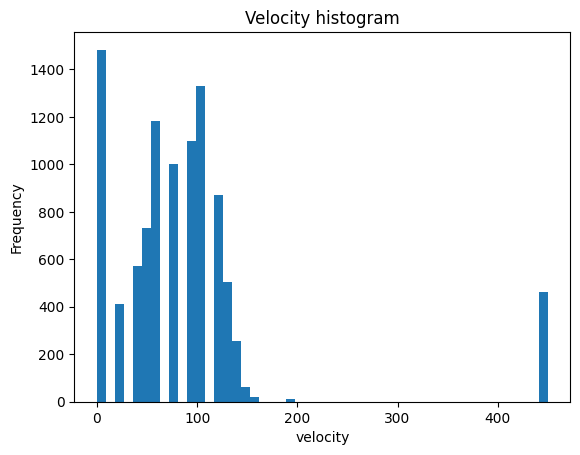

/var/folders/wg/fhyh82z92tggqh_lpzr0bhf00000gn/T/ipykernel_24526/4083013367.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  (s["ts_utc"].dt.floor("H")


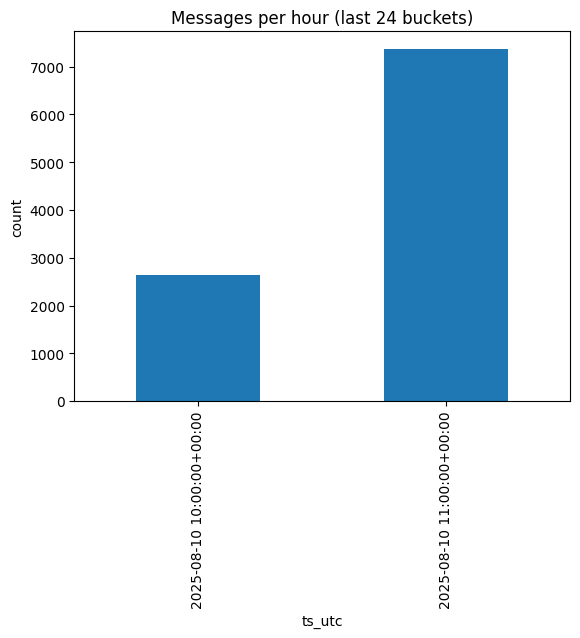

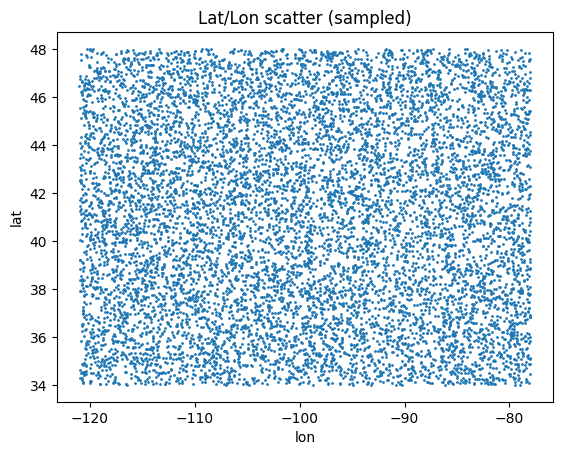

In [106]:
s = df.sample(min(len(df), 50_000), random_state=42)

s["velocity"].dropna().plot(kind="hist", bins=50, title="Velocity histogram")
plt.xlabel("velocity")
plt.show()

(s["ts_utc"].dt.floor("H")
   .value_counts()
   .sort_index()
   .tail(24)
   .plot(kind="bar", title="Messages per hour (last 24 buckets)"))
plt.ylabel("count")
plt.show()

if {"latitude","longitude"}.issubset(s.columns):
    plt.figure()
    plt.scatter(s["longitude"], s["latitude"], s=1)
    plt.title("Lat/Lon scatter (sampled)")
    plt.xlabel("lon"); plt.ylabel("lat")
    plt.show()

In [107]:
s[s["velocity"] > 300].head(3)

,vin,manufacturer,year,model,latitude,longitude,timestamp,velocity,frontLeftDoorState,wipersState,gearPosition,driverSeatbeltState,ts_utc,date,hour
4684,4T1BF1FK8FUB03575,Toyota,2015,Camry,45.62,-81.41,1754824335109,450,None,None,2,LOCKED,2025-08-10 11:12:15.109000+00:00,2025-08-10,11
576,4T1BF1FK8FUB03575,Toyota,2015,Camry,42.13,-78.75,1754823121107,450,UNLOCKED,False,6,LOCKED,2025-08-10 10:52:01.107000+00:00,2025-08-10,10
8158,4T1BF1FK8FUB03575,Toyota,2015,Camry,40.99,-94.95,1754824647111,450,UNLOCKED,True,5,LOCKED,2025-08-10 11:17:27.111000+00:00,2025-08-10,11


In [108]:
df.loc[df["vin"] == "4T1BF1FK8FUB03575", "velocity"].unique()

array([450])

### Observations:
- VIN missing in 428 rows
- door/seatbelt/wipers/gear have notable nulls → likely optional telemetry or not reported for all vehicles.
- timestamp is clean, no nulls. ts_utc is already timezone-aware.
- All date/hour partition values match the UTC timestamp range
- Gear have some weird values, especially None and 0, which could both might mean NEUTRAL.
- There are some (vin, timestamp) duplicates.
- There are **only 21 unique VINs!**
- Geolocation seems like a sample from a uniform distribution - **sensors might be randomizing location!**
- Some **velocity outliers** were detected. It seems that VIN 4T1BF1FK8FUB03575 constantly reports a speed of 450 (and it's a Toyota Camry 2015..)
- **Ingestion seems mostly correct**, with a couple of things that need to be addressed.


## Silver Analysis

                 vin manufacturer  year    model  latitude  longitude  \
0  1C4NJDBB0GD610265         Jeep  2016  Compass     47.27     -89.30   
1  1C4NJDBB0GD610265         Jeep  2016  Compass     37.69     -90.89   
2  1C4NJDBB0GD610265         Jeep  2016  Compass     36.62     -86.11   

       timestamp  velocity frontLeftDoorState wipersState  gearPosition  \
0  1754822684106         0             LOCKED       False             6   
1  1754822701102       100           UNLOCKED        None             3   
2  1754822714109        90           UNLOCKED        None             1   

  driverSeatbeltState                           ts_utc        date hour  
0                None 2025-08-10 10:44:44.106000+00:00  2025-08-10   10  
1              LOCKED 2025-08-10 10:45:01.102000+00:00  2025-08-10   10  
2              LOCKED 2025-08-10 10:45:14.109000+00:00  2025-08-10   10  
rows: 8126
gear dtype / min / max: int16 -1 6
trailing-space manufacturers: 0
non-integer gears present: 0
Veh

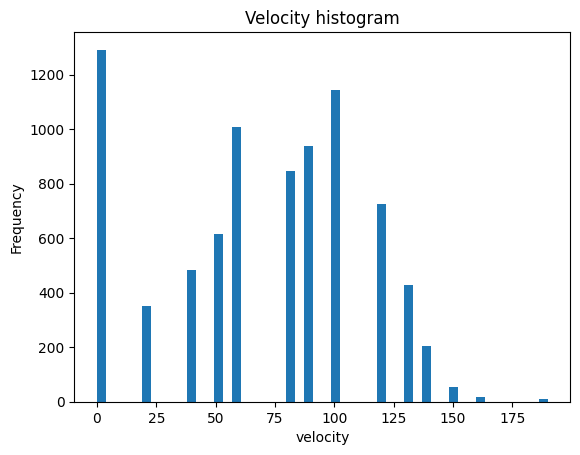

In [109]:
df = pd.read_parquet("messages_silver")

print(df.head(3))
s = df.sample(min(len(df), 50_000), random_state=42)

print("rows:", len(df))
print("gear dtype / min / max:", df["gearPosition"].dtype, df["gearPosition"].min(), df["gearPosition"].max())
print("trailing-space manufacturers:", df["manufacturer"].str.contains(r"\s$").sum())
print("non-integer gears present:", (~df["gearPosition"].apply(float.is_integer)).sum() if df["gearPosition"].dtype.kind=='f' else 0)
print(f"Vehicles with velocity < 0 or > 300: {(df['velocity'] < 0).sum() + (df['velocity'] > 300).sum()}")

s["velocity"].dropna().plot(kind="hist", bins=50, title="Velocity histogram")
plt.xlabel("velocity")
plt.show()

## Gold Analysis

In [110]:
vin_last_state = pd.read_parquet("messages_gold/vin_last_state.parquet")

print("[VIN LAST STATE SAMPLE]")
display(vin_last_state.head())
print(f"Total VINs: {vin_last_state['vin'].nunique()}")

print("\nDoor state distribution:")
print(vin_last_state["front_left_door_state"].value_counts(dropna=False))

print("\nWipers state distribution:")
print(vin_last_state["wipers_state"].value_counts(dropna=False))


[VIN LAST STATE SAMPLE]


,vin,last_reported_timestamp,front_left_door_state,wipers_state
0,1C4NJDBB0GD610265,2025-08-10 11:44:34.103000+00:00,LOCKED,False
1,1D3HW58J16S586904,2025-08-10 11:43:57.106000+00:00,LOCKED,True
2,1FMYU96H95KD42711,2025-08-10 11:44:34.110000+00:00,LOCKED,False
3,1G4AP6949BX114240,2025-08-10 11:44:30.103000+00:00,UNLOCKED,False
4,3C3CFFJH9DT711213,2025-08-10 11:44:33.107000+00:00,UNLOCKED,False


Total VINs: 21

Door state distribution:
front_left_door_state
UNLOCKED    11
LOCKED      10
Name: count, dtype: int64

Wipers state distribution:
wipers_state
False    20
True      1
Name: count, dtype: int64


## Top speed report

In [111]:
top_fastest = pd.read_csv("reports/top_fastest_per_hour.csv")

print("\n[TOP FASTEST PER HOUR]")
display(top_fastest.head(10))

print("\nTop velocity stats:")
print(top_fastest["top_velocity"].describe())


[TOP FASTEST PER HOUR]


,date_hour,vin,top_velocity
0,2025-08-10 10:00:00+00:00,WDBCB20AXEA063442,190
1,2025-08-10 10:00:00+00:00,WVWHP9AN8AE560303,190
2,2025-08-10 10:00:00+00:00,1C4NJDBB0GD610265,160
3,2025-08-10 10:00:00+00:00,1D3HW58J16S586904,160
4,2025-08-10 10:00:00+00:00,3C3CFFJH9DT711213,160
5,2025-08-10 10:00:00+00:00,9BWEL41J484018815,160
6,2025-08-10 10:00:00+00:00,JN1CV6FH0A0017612,160
7,2025-08-10 10:00:00+00:00,YV1CZ852051206734,160
8,2025-08-10 10:00:00+00:00,1G4AP6949BX114240,150
9,2025-08-10 10:00:00+00:00,4TAPN62N0TZ087521,150



Top velocity stats:
count     20.000000
mean     171.000000
std       16.189665
min      150.000000
25%      160.000000
50%      160.000000
75%      190.000000
max      190.000000
Name: top_velocity, dtype: float64
